#  VibeSnitch-AI | Personality Detection 
---

##  Objective:
To build a machine learning model that predicts a person's **MBTI personality type** based on their written text (social media posts).

We will use the **MBTI dataset** from Kaggle, which contains ~8.6k user profiles with 50 posts each and a corresponding MBTI label (e.g., INFP, ENTJ).

---

## Overview of Dataset:
The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:
```
Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
```
---


## Data Reading

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


df = pd.read_csv("../data/mbti_1.csv")
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [2]:
df.describe(include='O')

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'It has been too long since I have been on per...
freq,1832,1


In [3]:
df['type'].value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
df.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...


Above data show that there are many links in the text data. That needed to be removed.

---

## Data Cleaning

In [6]:
def clean_text_column(text_series):
    #  Drop Null
    text_series = text_series.dropna()
    
    # Lowercase
    text_series = text_series.str.lower()
    
    #  Remove URLs
    text_series = text_series.apply(lambda x: re.sub(r'http\S+|www\.\S+', '', x))
    
    #  Remove special separators (like |||)
    text_series = text_series.str.replace(r'\|\|\|', ' ', regex=True)
    
    #  Remove punctuation
    text_series = text_series.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    
    #  Remove stopwords but keep negations
    stop_words = set(stopwords.words('english'))
    stop_words.difference_update({"not", "no", "don't", "never"})
    text_series = text_series.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    #  Lemmatization
    lemmatizer = WordNetLemmatizer()
    text_series = text_series.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    
    return text_series

In [7]:
df['posts'] = clean_text_column(df['posts'])

---
Checking Cleaned Data

---

In [8]:
print(df['posts'][0])

intj moment sportscenter not top ten play prank lifechanging experience life repeat today may perc experience immerse last thing infj friend posted facebook committing suicide next day rest peace enfj7 sorry hear distress natural relationship not perfection time every moment existence try figure hard time time growth 84389 84390 welcome stuff game set match prozac wellbrutin least thirty minute moving leg dont mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item youve determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective not completely promoting death given sim dear enfp favorite video game growing current favorite video game cool appears late sad there someone everyone wait thought confidence good thing cherish time solitude bc revel within inner world whereas time id workin enjoy time dont worry people 

---
Saving cleaned data set

---

In [9]:
df.to_csv('../data/cleaned_dataset.csv', index=False)


---

## EDA and Visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df = pd.read_csv("../data/cleaned_dataset.csv")

####  Count of Each MBTI Type

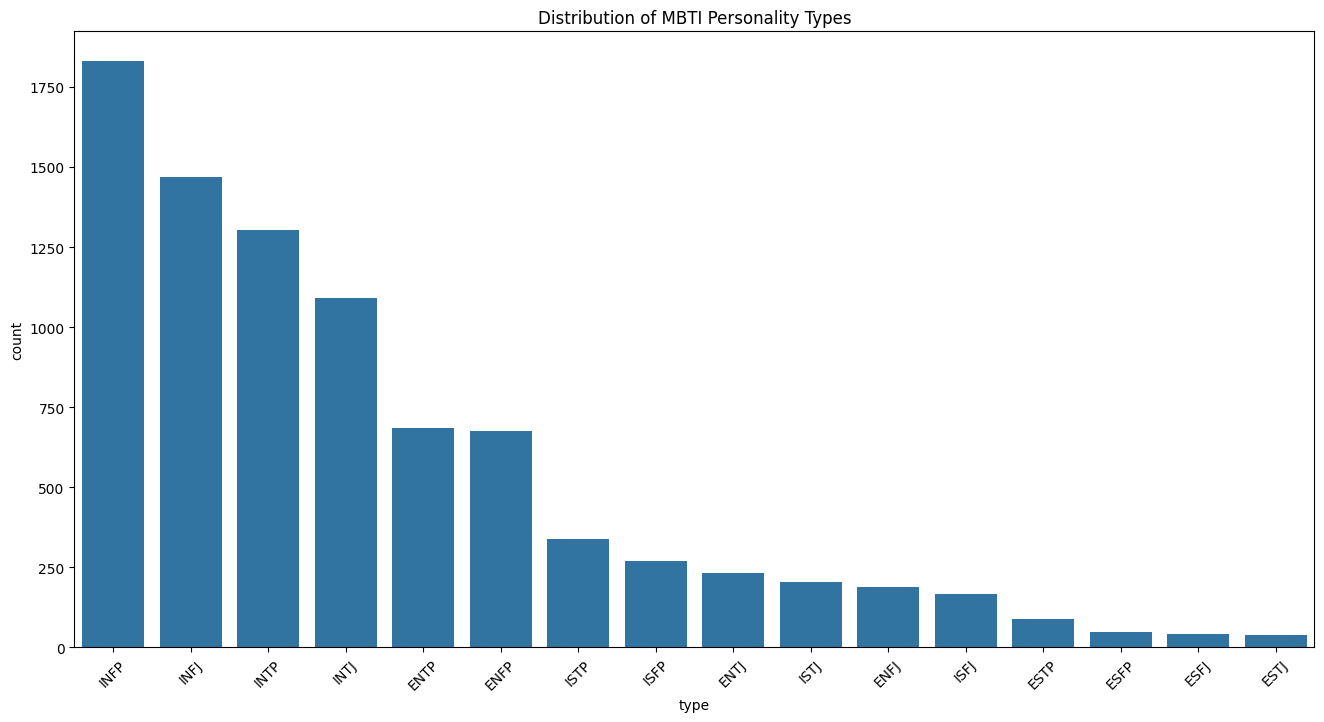

In [11]:
plt.figure(figsize=(16, 8))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title('Distribution of MBTI Personality Types')
plt.xticks(rotation=45)
plt.show()


#### Post Length Distribution

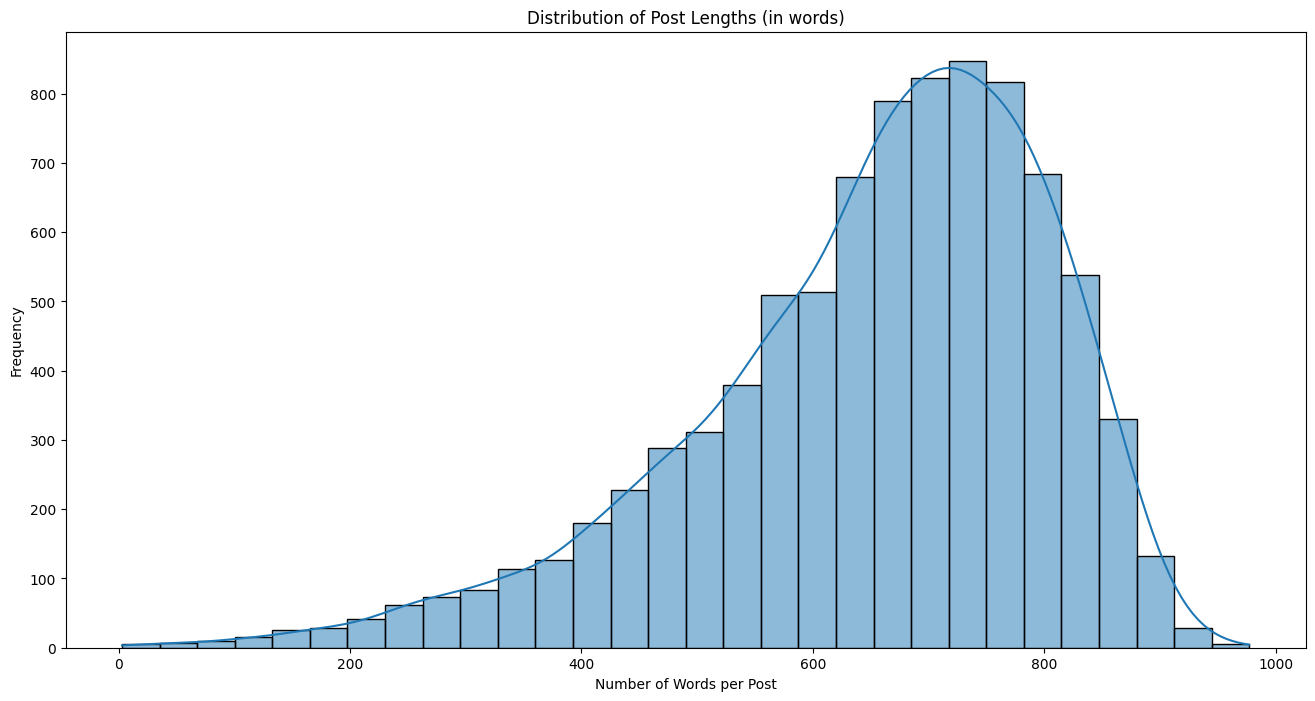

In [12]:
df['post_length'] = df['posts'].apply(lambda x: len(x.split()))

plt.figure(figsize=(16, 8))
sns.histplot(df['post_length'], bins=30, kde=True)
plt.title('Distribution of Post Lengths (in words)')
plt.xlabel('Number of Words per Post')
plt.ylabel('Frequency')
plt.show()


#### Word Cloud (for all posts)

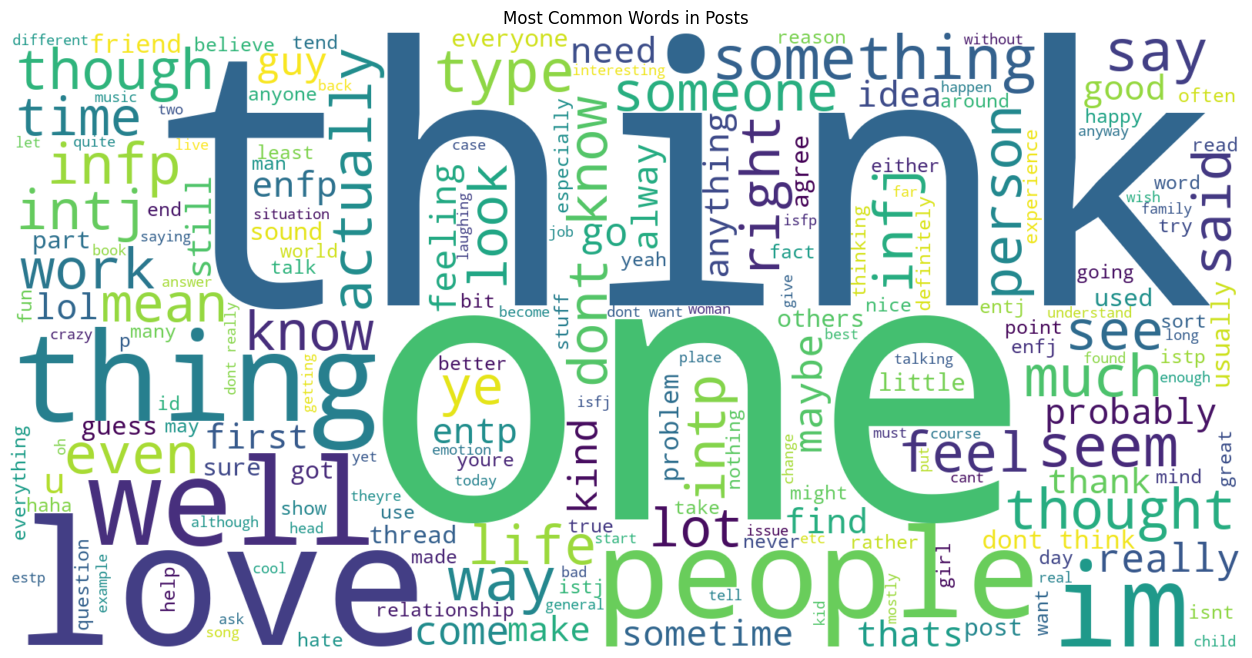

In [13]:
from wordcloud import STOPWORDS

all_text = ' '.join(df['posts'])
wordcloud = WordCloud(width=1600, height=800, background_color='white',
                      stopwords=STOPWORDS).generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Posts')
plt.show()


#### Top Words per Personality Type


In [14]:
from collections import Counter

types = df['type'].unique()
for t in types[:4]:  # showing for 4 types only to keep output short
    words = ' '.join(df[df['type'] == t]['posts']).split()
    common_words = Counter(words).most_common(10)
    print(f"{t}: {common_words}")


INFJ: [('im', 14059), ('not', 12489), ('like', 12007), ('think', 8963), ('dont', 8786), ('people', 8582), ('know', 7034), ('one', 6848), ('really', 6159), ('thing', 6085)]
ENTP: [('im', 5902), ('not', 5468), ('like', 5400), ('dont', 4023), ('think', 3999), ('people', 3694), ('one', 3213), ('know', 2858), ('get', 2705), ('would', 2658)]
INTP: [('not', 11176), ('im', 10769), ('like', 9796), ('dont', 8017), ('think', 7248), ('people', 7089), ('one', 5817), ('would', 5600), ('know', 5172), ('thing', 4834)]
INTJ: [('not', 9770), ('im', 8216), ('like', 7880), ('dont', 6521), ('people', 5923), ('think', 5663), ('one', 4964), ('would', 4679), ('know', 4409), ('intj', 4124)]


---

## Text Preprocessing and Feature Engineering

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

 
df = pd.read_csv('../data/cleaned_dataset.csv') 
df.head()

,type,posts
0,INFJ,intj moment sportscenter not top ten play pran...
1,ENTP,im finding lack post alarming sex boring posit...
2,INTP,good one course say know thats blessing curse ...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,youre fired thats another silly misconception ...


In [16]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])


label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("MBTI Type to Label mapping:")
print(label_mapping)


MBTI Type to Label mapping:
{'ENFJ': np.int64(0), 'ENFP': np.int64(1), 'ENTJ': np.int64(2), 'ENTP': np.int64(3), 'ESFJ': np.int64(4), 'ESFP': np.int64(5), 'ESTJ': np.int64(6), 'ESTP': np.int64(7), 'INFJ': np.int64(8), 'INFP': np.int64(9), 'INTJ': np.int64(10), 'INTP': np.int64(11), 'ISFJ': np.int64(12), 'ISFP': np.int64(13), 'ISTJ': np.int64(14), 'ISTP': np.int64(15)}


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df['posts'])
print(f"Total unique words: {len(vectorizer.vocabulary_)}")                     


Total unique words: 148349


In [18]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['posts'])  #input features
y = df['label'] #target labels


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
with open('../models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

df.to_csv('../data/mbti_labeled_cleaned.csv', index=False)

print(" All preprocessing done. Data saved for model training.")


 All preprocessing done. Data saved for model training.


---

## MODEL TRAINING

### 1. Logistic Regression

#### Train Logistic Regression Model


In [21]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced')
model_LR.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

#### Predict & Evaluate

Train Accuracy: 0.8145533141210375
Test Accuracy: 0.6743515850144092

Train Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.70      0.97      0.81       149
        ENFP       0.78      0.78      0.78       550
        ENTJ       0.69      0.89      0.78       187
        ENTP       0.79      0.81      0.80       550
        ESFJ       0.70      1.00      0.82        35
        ESFP       0.56      1.00      0.72        40
        ESTJ       0.91      1.00      0.96        32
        ESTP       0.73      1.00      0.84        74
        INFJ       0.89      0.74      0.81      1182
        INFP       0.86      0.80      0.83      1462
        INTJ       0.83      0.78      0.81       898
        INTP       0.84      0.81      0.83      1011
        ISFJ       0.72      0.98      0.83       121
        ISFP       0.74      0.92      0.82       218
        ISTJ       0.76      0.95      0.85       161
        ISTP       0.76      0.93   

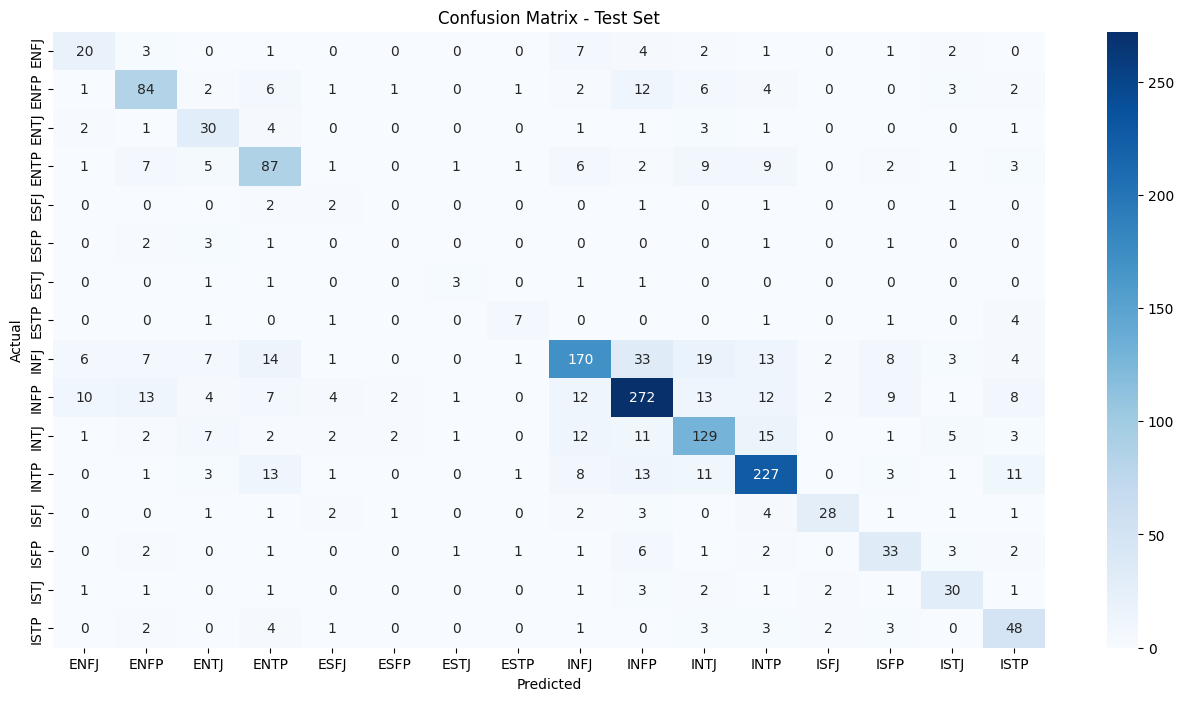

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_train, y_train, X_test, y_test, label_encoder):
    print("Train Accuracy:", accuracy_score(y_train, model.predict(X_train)))
    print("Test Accuracy:", accuracy_score(y_test, model.predict(X_test)))

    print("\nTrain Classification Report:")
    print(classification_report(y_train, model.predict(X_train), target_names=label_encoder.classes_, zero_division=0))

    print("\nTest Classification Report:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cmap='Blues')
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(model_LR, X_train, y_train, X_test, y_test, label_encoder)

### 2. Multinominal Naive Bayes

#### Train M.N.B Model

In [23]:
from sklearn.naive_bayes import MultinomialNB

model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)

MultinomialNB()

#### Evaluate


Train Accuracy: 0.4538904899135447
Test Accuracy: 0.3659942363112392

Train Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       149
        ENFP       0.71      0.03      0.05       550
        ENTJ       0.00      0.00      0.00       187
        ENTP       0.91      0.05      0.10       550
        ESFJ       0.00      0.00      0.00        35
        ESFP       0.00      0.00      0.00        40
        ESTJ       0.00      0.00      0.00        32
        ESTP       0.00      0.00      0.00        74
        INFJ       0.51      0.62      0.56      1182
        INFP       0.34      0.95      0.51      1462
        INTJ       0.78      0.44      0.56       898
        INTP       0.64      0.59      0.61      1011
        ISFJ       0.00      0.00      0.00       121
        ISFP       0.00      0.00      0.00       218
        ISTJ       0.00      0.00      0.00       161
        ISTP       0.00      0.00   

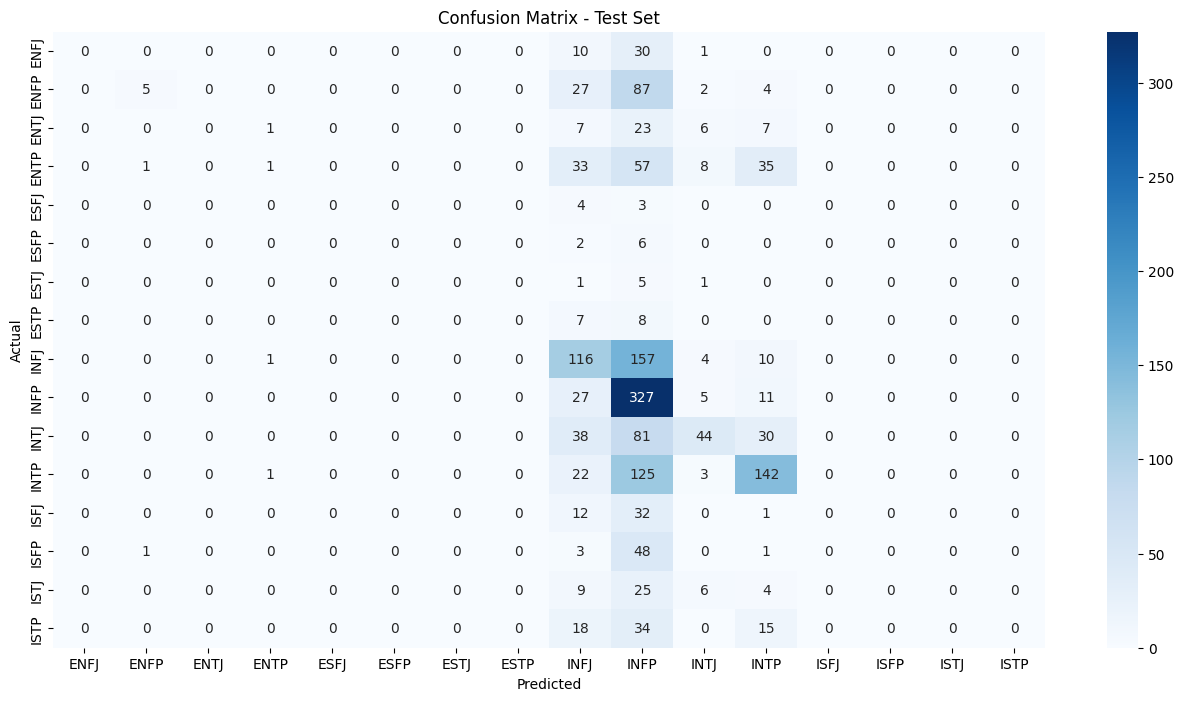

In [24]:
evaluate_model(model_mnb, X_train, y_train, X_test, y_test, label_encoder)

### 3.Linear Support Vector Classifier  

#### Train Model

In [25]:
from sklearn.svm import LinearSVC

model_svc = LinearSVC(class_weight='balanced', C=0.1)
model_svc.fit(X_train, y_train)


LinearSVC(C=0.1, class_weight='balanced')

#### Evaluate

Train Accuracy: 0.8381844380403458
Test Accuracy: 0.6726224783861672

Train Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.70      0.95      0.81       149
        ENFP       0.81      0.81      0.81       550
        ENTJ       0.72      0.89      0.80       187
        ENTP       0.83      0.83      0.83       550
        ESFJ       0.65      1.00      0.79        35
        ESFP       0.56      0.97      0.71        40
        ESTJ       0.86      1.00      0.93        32
        ESTP       0.67      0.97      0.79        74
        INFJ       0.90      0.78      0.84      1182
        INFP       0.89      0.84      0.86      1462
        INTJ       0.88      0.79      0.83       898
        INTP       0.88      0.84      0.86      1011
        ISFJ       0.72      0.96      0.82       121
        ISFP       0.76      0.89      0.82       218
        ISTJ       0.75      0.95      0.84       161
        ISTP       0.76      0.95   

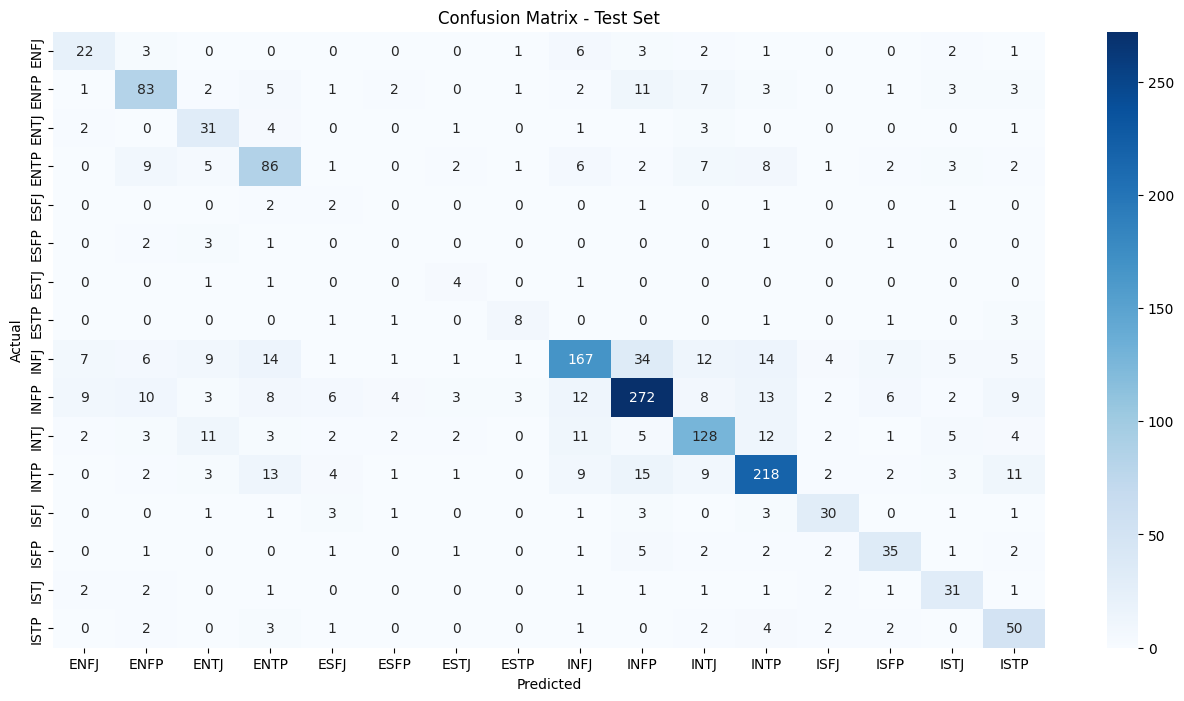

In [26]:
evaluate_model(model_svc, X_train, y_train, X_test, y_test, label_encoder)

### Best Choice - According to results

Based on the results, **Logistic Regression (LR)** seems to be the **best choice** because:

* It has the best balance between train and test accuracy.
* **LinearSVC** has higher training accuracy, but it’s overfitting.
* **Multinomial Naive Bayes (MNB)** underperforms on both train and test data.



#### Visualize Accuracy of All Models

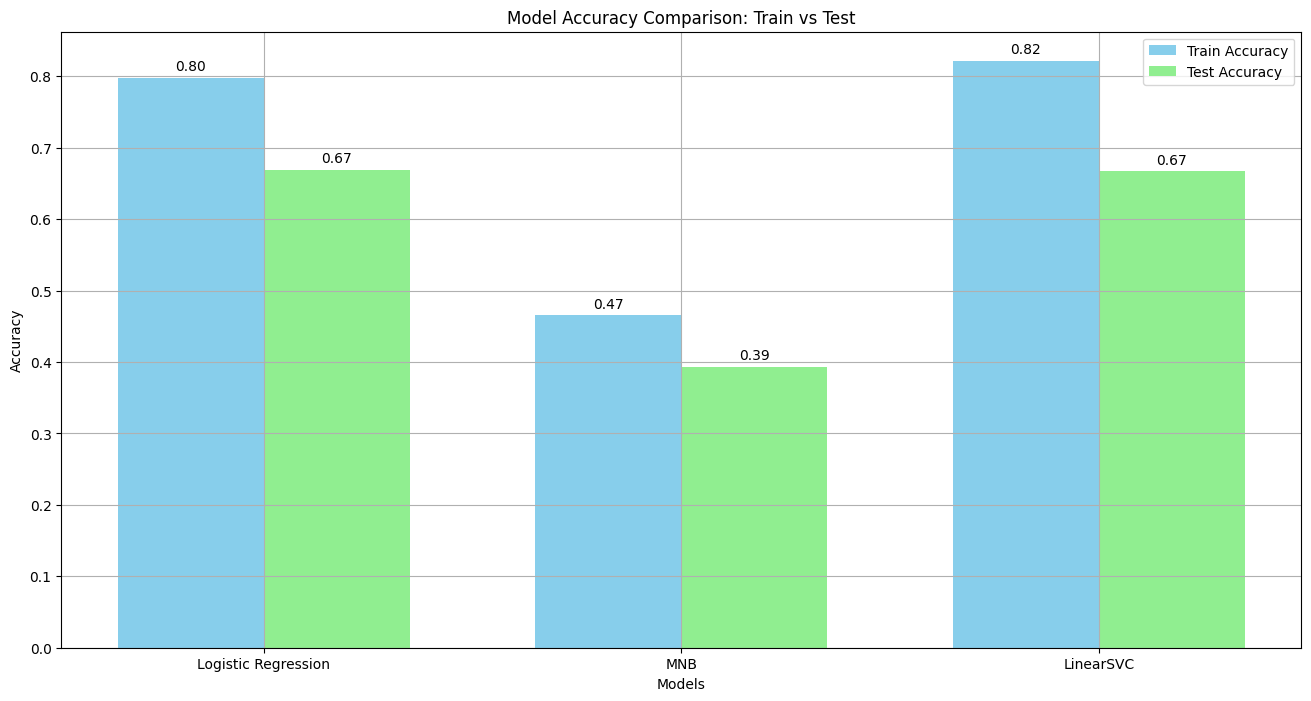

In [27]:
# Accuracy values for all models
models = ['Logistic Regression', 'MNB', 'LinearSVC']
train_accuracies = [0.7979827089337176, 0.4654178674351585, 0.8211815561959654]
test_accuracies = [0.669164265129683, 0.3930835734870317, 0.6668587896253603]

x = np.arange(len(models))  
width = 0.35 

fig, ax = plt.subplots(figsize=(16, 8))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='lightgreen')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.grid(True)
plt.show()



---
## Pipelines Creation

we re-implement our preprocessing and model training using `Pipeline` from scikit-learn. This will Combine cleaning, vectorization, and modeling into one step.


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#### Load dataset

In [29]:
df = pd.read_csv('../data/mbti_labeled_cleaned.csv')
with open('../models/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

X = df['posts']
y = df['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Create TextCleaner

In [30]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.difference_update({"not", "no", "don't", "never"})
        self.lemmatizer = WordNetLemmatizer()

    def clean(self, text):
        if not isinstance(text, str): return ""
        text = text.lower()
        text = re.sub(r'http\S+|www\.\S+', '', text)
        text = re.sub(r'\|\|\|', ' ', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = [w for w in text.split() if w not in self.stop_words]
        words = [self.lemmatizer.lemmatize(w) for w in words]
        return ' '.join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Handles both pandas Series and Python list
        return pd.Series(X).apply(self.clean)


#### Pipelines for all 3 models

In [31]:
# LR
pipeline_lr = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# NBP
pipeline_nbp = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

# LSVM
pipeline_lsvc = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LinearSVC(class_weight='balanced', C=0.1))
])


#### Train Pipelines

In [32]:
pipeline_lr.fit(X_train_raw, y_train)
pipeline_nbp.fit(X_train_raw, y_train)
pipeline_lsvc.fit(X_train_raw, y_train)

Pipeline(steps=[('cleaner', TextCleaner()),
                ('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf', LinearSVC(C=0.1, class_weight='balanced'))])

Evaluate all 3 pipelines

Logistic Regression
Train Accuracy: 0.8157060518731989
Test Accuracy: 0.6731988472622479

Train Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.70      0.97      0.81       149
        ENFP       0.78      0.78      0.78       550
        ENTJ       0.69      0.89      0.77       187
        ENTP       0.79      0.82      0.81       550
        ESFJ       0.70      1.00      0.82        35
        ESFP       0.56      1.00      0.72        40
        ESTJ       0.91      1.00      0.96        32
        ESTP       0.73      1.00      0.85        74
        INFJ       0.89      0.74      0.81      1182
        INFP       0.87      0.80      0.83      1462
        INTJ       0.83      0.79      0.81       898
        INTP       0.84      0.81      0.83      1011
        ISFJ       0.72      0.98      0.83       121
        ISFP       0.74      0.92      0.82       218
        ISTJ       0.76      0.95      0.85       161
        ISTP    

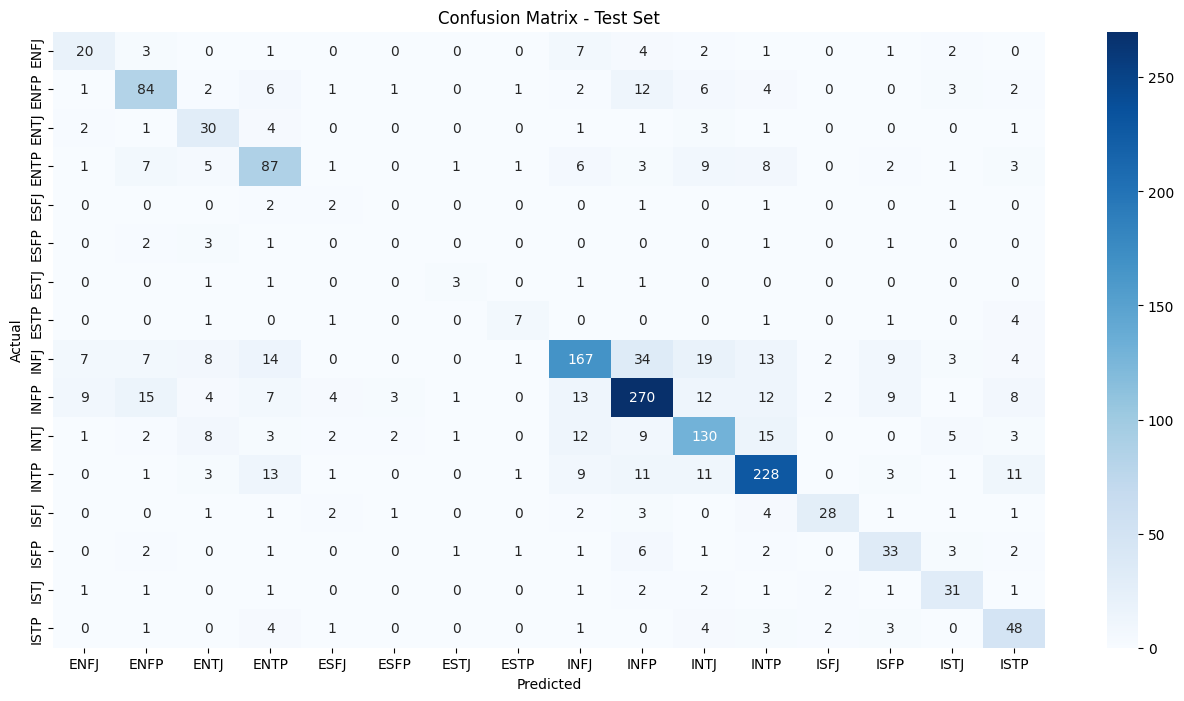

Naive Bayes
Train Accuracy: 0.45605187319884727
Test Accuracy: 0.3631123919308357

Train Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       149
        ENFP       0.78      0.03      0.06       550
        ENTJ       0.00      0.00      0.00       187
        ENTP       0.92      0.06      0.11       550
        ESFJ       0.00      0.00      0.00        35
        ESFP       0.00      0.00      0.00        40
        ESTJ       0.00      0.00      0.00        32
        ESTP       0.00      0.00      0.00        74
        INFJ       0.51      0.62      0.56      1182
        INFP       0.35      0.95      0.51      1462
        INTJ       0.77      0.44      0.56       898
        INTP       0.63      0.59      0.61      1011
        ISFJ       0.00      0.00      0.00       121
        ISFP       0.00      0.00      0.00       218
        ISTJ       0.00      0.00      0.00       161
        ISTP       0.00

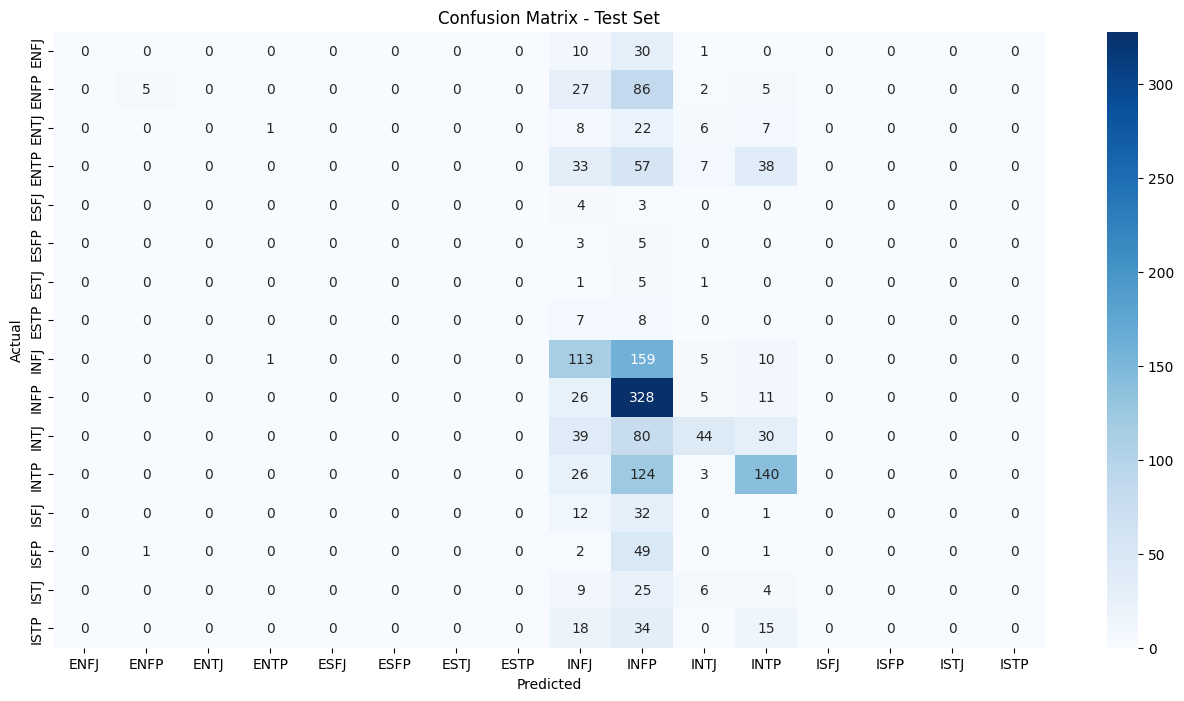

Linear SVC
Train Accuracy: 0.8381844380403458
Test Accuracy: 0.6755043227665706

Train Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.71      0.95      0.81       149
        ENFP       0.81      0.81      0.81       550
        ENTJ       0.72      0.89      0.80       187
        ENTP       0.82      0.83      0.83       550
        ESFJ       0.65      1.00      0.79        35
        ESFP       0.57      0.97      0.72        40
        ESTJ       0.86      1.00      0.93        32
        ESTP       0.67      0.97      0.79        74
        INFJ       0.90      0.78      0.84      1182
        INFP       0.89      0.84      0.86      1462
        INTJ       0.88      0.79      0.83       898
        INTP       0.88      0.84      0.86      1011
        ISFJ       0.71      0.96      0.82       121
        ISFP       0.76      0.89      0.82       218
        ISTJ       0.75      0.95      0.84       161
        ISTP       0.77  

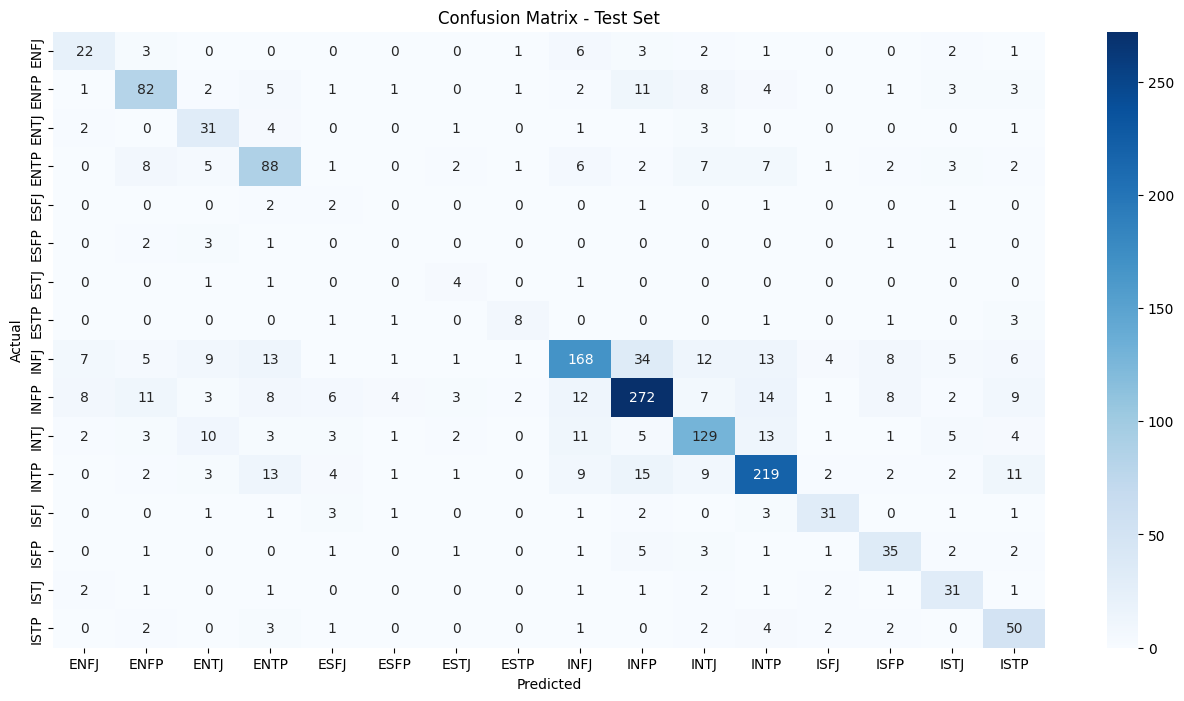

In [33]:
print("Logistic Regression")
evaluate_model(pipeline_lr, X_train_raw, y_train, X_test_raw, y_test, label_encoder)

print("Naive Bayes")
evaluate_model(pipeline_nbp, X_train_raw, y_train, X_test_raw, y_test, label_encoder)

print("Linear SVC")
evaluate_model(pipeline_lsvc, X_train_raw, y_train, X_test_raw, y_test, label_encoder)

In [34]:
with open('../models/personality_pipeline_lr.pkl', 'wb') as f:
    pickle.dump(pipeline_lr, f)

with open('../models/personality_pipeline_nbp.pkl', 'wb') as f:
    pickle.dump(pipeline_nbp, f)

with open('../models/personality_pipeline_lsvc.pkl', 'wb') as f:
    pickle.dump(pipeline_lsvc, f)

print("All models and pipeline saved!")

All models and pipeline saved!


---
All pipelines and encoder saved successfully.
You can now close this notebook.
Move on to GUI integration or API deployment.
VibeSnitch AI – Training Complete!

## The End!